In [1]:
# Don't worry about the warnings from this library.
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
library(ggplot2)
library(reshape2)

In [3]:
get_scouting_data <- function(input_filename) {
    #
    # This function reads the scouting data, cleans some of the data and renames the columns.
    #
    data <- read.csv(input_filename)

    # Set empty cells to 0
    data[is.na(data)] <- 0

    # Convert Climbing column to a numeric value.
    NumericClimb <- list('Level 3' = 12, 'Level 2' = 6, 'Level 1' = 3, 'Not on HAB' = 0)
    data[,'Climbing'] <- mapply(function(x) NumericClimb[[x]], as.vector(data[,'Climbing']))

    # Convert percentage column to numeric value
    data[,'FractionDefense'] <- mapply(function(x) as.numeric(strsplit(x, '%')), as.vector(data[,'X..of.time.playing.defense']))

    data <- rename(data,
        ScoutName = Your.name..FirstName.LastName.,
        Match = Match..,
        Team = Team..,
        StartPosition = Starting.Position,
        StartLevel2 = Starts.on.Level.2.,
        MovedSandstorm = Moved.during.sandstorm.,
        HabLine = Crossed.HAB.line.,
        StartingPiece = Starts.with,
        HatchSandstorm = X..of.hatch.panels.placed.during.sandstorm,
        CargoSandstorm = X..of.cargo.placed.during.sandstorm,
        HatchCargoBay = X..of.hatch.panels.on.the.cargo.bay,
        HatchBottomRocket = X..of.hatch.panels.on.the.bottom.of.the.rocket,
        HatchMidRocket = X..of.hatch.panels.on.the.middle.of.the.rocket,
        HatchTopRocket = X..of.hatch.panels.on.the.top.of.the.rocket,
        HatchMissed = X..of.hatch.panels.missed,
        CargoCargoBay = X..of.cargo.in.the.cargo.bay,
        CargoBottomRocket = X..of.cargo.in.the.bottom.of.the.rocket,
        CargoMidRocket = X..of.cargo.in.the.middle.of.the.rocket,
        CargoTopRocket = X..of.cargo.in.the.top.of.the.rocket,
        CargoMissed = X..of.cargo.missed,
        DefenseSuccess = Played.defense.successfully,
        WeakDefense = Weak.to.defense..tippy..easily.pushed..etc.,
        PercentDefense = X..of.time.playing.defense,
        Fouls = X..of.fouls,
        TechFouls = X..of.tech.fouls,
        RobotDisabled = Robot.disabled,
        RobotFail = Robot.failure,
        TippedOver = Tipped.over,
        Reckless = Reckless.driving,
        YellowCard = Yellow.card,
        RedCard = Red.card
    )

    return(data)
}

In [4]:
get_summary_data <- function(input_filename) {
    #
    # This summary function is the same as used in the Google spreadsheet.
    #
    scouting_data <- get_scouting_data(input_filename)

    intermediate_summary <- summarise(group_by(scouting_data, Match, Team),
        HabScore = mean(3 * HabLine * (StartLevel2 + 1)),
        HatchScore = 2 * mean(HatchSandstorm + HatchCargoBay + HatchBottomRocket + HatchMidRocket + HatchTopRocket),
        CargoScore = 3 * mean(CargoSandstorm + CargoCargoBay + CargoBottomRocket + CargoMidRocket + CargoTopRocket),
        ClimbScore = mean(Climbing)
    )

    summary_data <- summarise(group_by(intermediate_summary, Team),
        HabScore = mean(HabScore),
        HatchScore = mean(HatchScore),
        CargoScore = mean(CargoScore),
        ClimbScore = mean(ClimbScore),
        Score = HabScore + HatchScore + CargoScore + ClimbScore
    )

    # Sort the teams by total score in descending order.
    sorted_data <- arrange(summary_data, desc(Score))

    return(sorted_data)
}

In [5]:
get_summary_data_poc <- function(input_filename) {
    #
    # This summary function is just a proof of concept.
    #
    scouting_data <- get_scouting_data(input_filename)

    intermediate_summary <- summarise(group_by(scouting_data, Match, Team),
        HabScore = mean(3 * HabLine * (StartLevel2 + 1)),
        HatchScore = 2 * mean(HatchSandstorm + HatchCargoBay + HatchBottomRocket + 1.1 * HatchMidRocket + 1.1 * HatchTopRocket),
        CargoScore = 3 * mean(CargoSandstorm + CargoCargoBay + CargoBottomRocket + 1.1 * CargoMidRocket + 1.1 * CargoTopRocket),
        ClimbScore = mean(Climbing),
        DefenseScore = mean(10 * DefenseSuccess * FractionDefense / 100),
        FoulScore = mean(3 * Fouls + 10 * TechFouls),
        FailScore = 5 * mean(RobotDisabled + RobotFail + TippedOver + Reckless),
    )

    # Find the worst Foul/Fail score
    max_foul_fail <- max(summarise(group_by(intermediate_summary, Team), Total = mean(FoulScore + FailScore))$Total)

    summary_data <- summarise(group_by(intermediate_summary, Team),
        HabScore = mean(HabScore),
        HatchScore = mean(HatchScore),
        CargoScore = mean(CargoScore),
        ClimbScore = mean(ClimbScore),
        DefenseScore = mean(DefenseScore),
        OppPenaltyScore = max_foul_fail - mean(FoulScore + FailScore),
        Score = HabScore + HatchScore + CargoScore + ClimbScore + DefenseScore + OppPenaltyScore
    )

    # Sort the teams by total score in descending order.
    sorted_data <- arrange(summary_data, desc(Score))

    return(sorted_data)
}

In [6]:
plot_scores <- function(summary_data, title = 'Scouting Data', horizontal = FALSE, output_filename = '') {
    #
    # Plot the scores (Google spreadsheet version)
    #
    summary_data <- melt(select(summary_data, Team:ClimbScore), id.vars = 'Team')
    summary_data$variable <- factor(summary_data$variable, levels = c('ClimbScore', 'CargoScore', 'HatchScore', 'HabScore'))

    if (horizontal) {
        p <- ggplot(data = summary_data, aes(x = reorder(Team, value), y = value, fill = variable)) + coord_flip()
    }
    else {
        p <- ggplot(data = summary_data, aes(x = reorder(Team, -value), y = value, fill = variable)) +
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    }

    p <- p + geom_bar(stat = 'identity', color = 'black') +
        labs(title = title, x = 'Team', y = 'Score') +
        theme(plot.title = element_text(hjust = 0.5)) +
        scale_fill_manual(name = '', values = c('green', 'yellow', 'red', 'blue'))

    print(p)

    # Add ggsave arguments width, height, and units to adjust output file size.
    if (output_filename != '') {
        ggsave(output_filename)
    }
}

In [7]:
plot_scores_poc <- function(summary_data, title = 'Scouting Data (POC)', horizontal = FALSE, output_filename = '') {
    #
    # Plot the scores (proof of concept)
    #
    summary_data <- melt(select(summary_data, Team:OppPenaltyScore), id.vars = 'Team')
    summary_data$variable <- factor(summary_data$variable, levels = c('OppPenaltyScore', 'DefenseScore', 'ClimbScore', 'CargoScore', 'HatchScore', 'HabScore'))

    if (horizontal) {
        p <- ggplot(data = summary_data, aes(x = reorder(Team, value), y = value, fill = variable)) + coord_flip()
    }
    else {
        p <- ggplot(data = summary_data, aes(x = reorder(Team, -value), y = value, fill = variable)) +
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
    }

    p <- p + geom_bar(stat = 'identity', color = 'black') +
        labs(title = title, x = 'Team', y = 'Score') +
        theme(plot.title = element_text(hjust = 0.5)) +
        scale_fill_manual(name = '', values = c('tan3', 'magenta', 'green', 'yellow', 'red', 'blue'))

    print(p)

    # Add ggsave arguments width, height, and units to adjust output file size.
    if (output_filename != '') {
        ggsave(output_filename)
    }
}

In [8]:
plot_total_score <- function(summary_data, title = 'Scouting Data', horizontal = FALSE, output_filename = '') {
    #
    # Plot the total score
    #
    summary_data <- select(summary_data, Team, Score)

    if (horizontal) {
        p <- ggplot(data = summary_data, aes(x = reorder(Team, Score), y = Score, fill = Score)) + coord_flip()
    }
    else {
        p <- ggplot(data = summary_data, aes(x = reorder(Team, -Score), y = Score, fill = Score)) +
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
    }

    p <- p + geom_bar(stat = 'identity', color = 'black') +
        labs(title = title, x = 'Team', y = 'Score') +
        theme(plot.title = element_text(hjust = 0.5))

    print(p)

    # Add ggsave arguments width, height, and units to adjust output file size.
    if (output_filename != '') {
        ggsave(output_filename)
    }
}

In [9]:
auburn_data <- get_summary_data('../Data/Scouting_2019/Auburn_MtView.csv')

In [10]:
auburn_data

Team,HabScore,HatchScore,CargoScore,ClimbScore,Score
2046,6.000000,8.5833333,12.5000000,9.500000,36.583333
1983,4.750000,5.1666667,11.7500000,11.000000,32.666667
2928,6.000000,6.0000000,3.0000000,6.000000,21.000000
2976,3.250000,5.6666667,8.7500000,2.250000,19.916667
4131,3.272727,4.5454545,9.2727273,2.181818,19.272727
5827,3.000000,6.5454545,0.0000000,9.545455,19.090909
948,4.750000,1.5000000,9.2500000,3.000000,18.500000
3588,4.500000,5.6666667,4.5000000,3.750000,18.416667
1903,0.000000,0.0000000,15.0000000,3.000000,18.000000
5450,2.000000,1.1111111,10.3333333,2.666667,16.111111


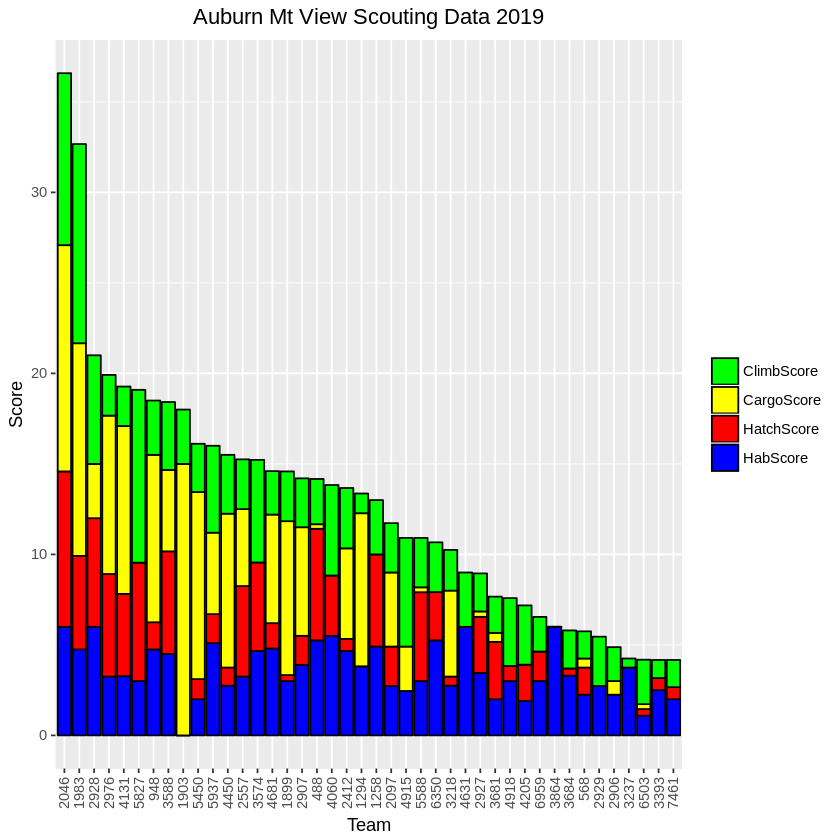

In [11]:
plot_scores(auburn_data, 'Auburn Mt View Scouting Data 2019')

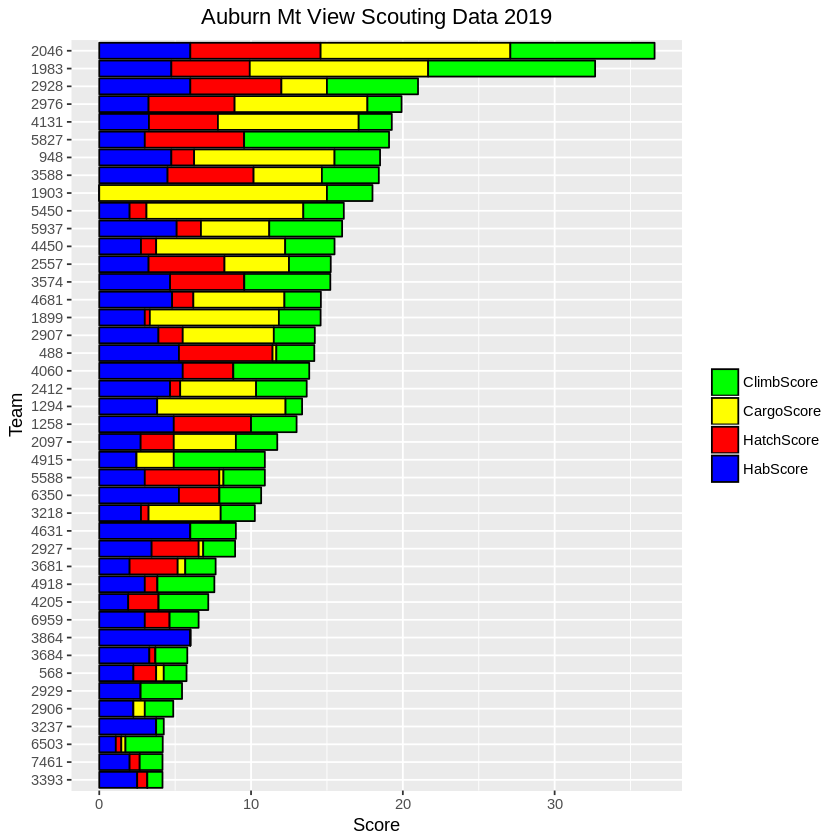

In [12]:
plot_scores(auburn_data, 'Auburn Mt View Scouting Data 2019', horizontal = TRUE)

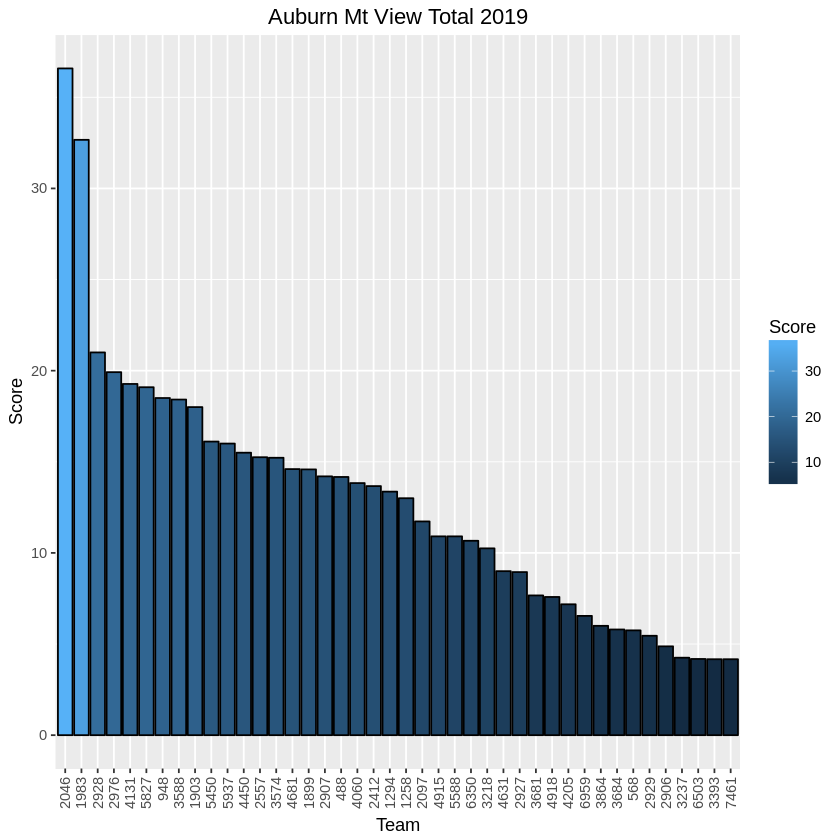

In [13]:
plot_total_score(auburn_data, 'Auburn Mt View Total 2019')

In [14]:
auburn_data_poc <- get_summary_data_poc('../Data/Scouting_2019/Auburn_MtView.csv')

In [15]:
auburn_data_poc

Team,HabScore,HatchScore,CargoScore,ClimbScore,DefenseScore,OppPenaltyScore,Score
2046,6.000000,9.0500000,13.0750000,9.500000,0.08333333,9.583333,47.29167
1983,4.750000,5.2000000,11.8250000,11.000000,0.33333333,10.000000,43.10833
2928,6.000000,6.4000000,3.0000000,6.000000,1.00000000,10.000000,32.40000
2976,3.250000,5.7500000,8.8000000,2.250000,0.08333333,9.583333,29.71667
4131,3.272727,4.5454545,9.2727273,2.181818,0.00000000,10.000000,29.27273
5827,3.000000,6.5454545,0.0000000,9.545455,0.00000000,10.000000,29.09091
3588,4.500000,5.8333333,4.5250000,3.750000,0.75000000,8.833333,28.19167
1903,0.000000,0.0000000,15.0000000,3.000000,0.00000000,10.000000,28.00000
948,4.750000,1.5000000,9.2500000,3.000000,0.33333333,8.750000,27.58333
2557,3.250000,5.1833333,4.3000000,2.750000,0.00000000,10.000000,25.48333


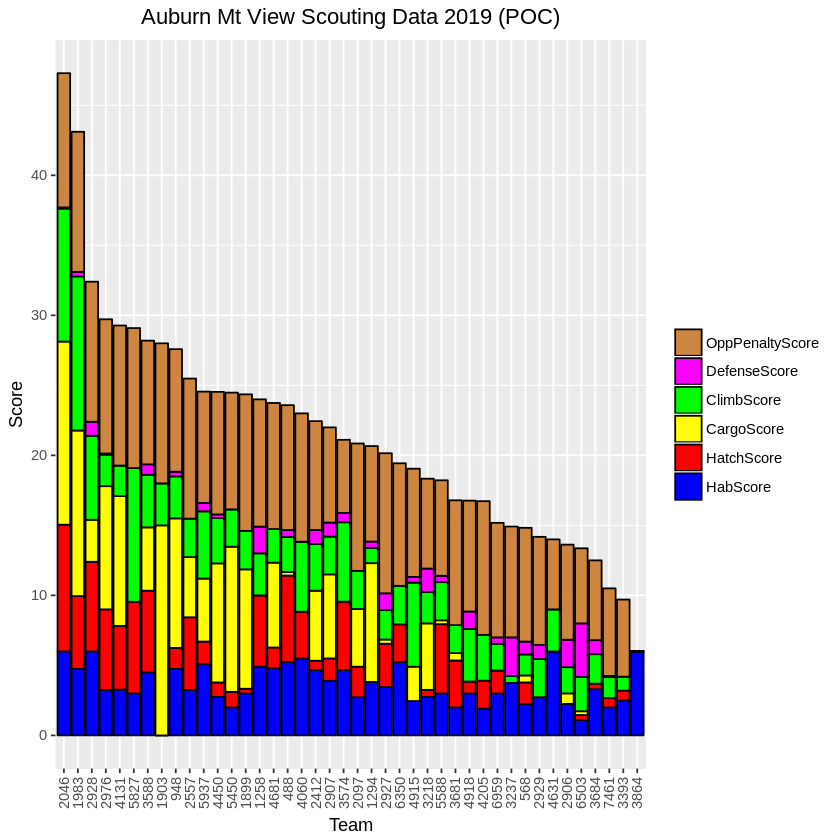

In [16]:
plot_scores_poc(auburn_data_poc, 'Auburn Mt View Scouting Data 2019 (POC)')

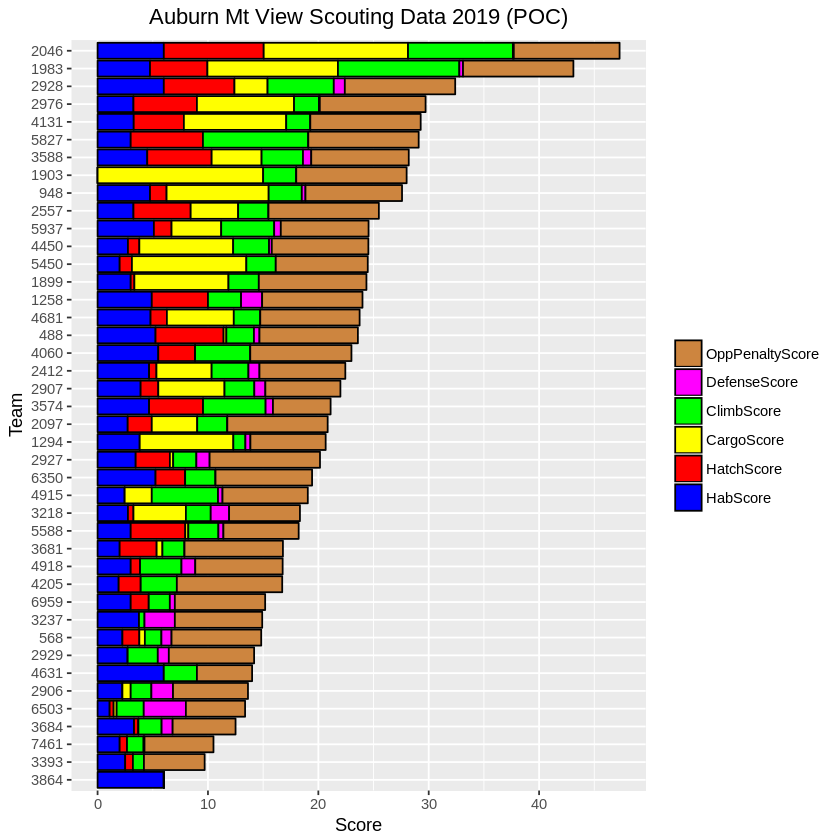

In [17]:
plot_scores_poc(auburn_data_poc, 'Auburn Mt View Scouting Data 2019 (POC)', horizontal = TRUE)